In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib
import numpy as np
import torch

import warp as wp
wp.config.quiet = True
wp.set_device('cpu')

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Wed Feb  4 03:08:29 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:25:00.0 Off |                  Off |
| 34%   49C    P8             26W /  300W |       5MiB /  49140MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
config = project.core.fileio.load_config('2026-02-02_config.yaml')

#config['dataset']['examples']['subjects'] = 'one_subject.csv'
#config['dataset']['examples']['subjects'] = 'ten_subjects.csv'
config['dataset']['examples']['subjects'] = '100_subjects.csv'
#config['dataset']['examples']['subjects'] = '2026-01-26_preprocessed.csv'

config['dataset']

Loading 2026-02-02_config.yaml


{'name': 'ShapeNet',
 'root': '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem',
 'examples': {'subjects': '100_subjects.csv', 'variant': '2026-01-15'},
 'metadata': {'parse_metadata': True,
  'unit_policy': 'prefer_metadata',
  'default_unit': 0.01},
 'selectors': {'material_mask': 'uniform-seed'}}

In [5]:
examples = project.api.get_examples(config['dataset'])
len(examples)

Gathering examples


100

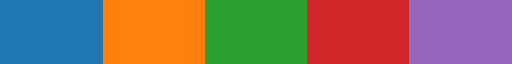

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
n_labels = 5
colors = plt.get_cmap('tab10').colors
cmap = ListedColormap(colors[:n_labels])

cmap.set_under('white')
cmap.set_over('black')
cmap.set_bad('black')
cmap

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_elastic.nii.gz


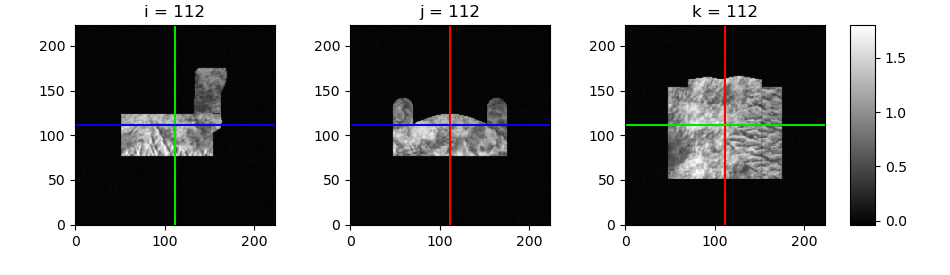

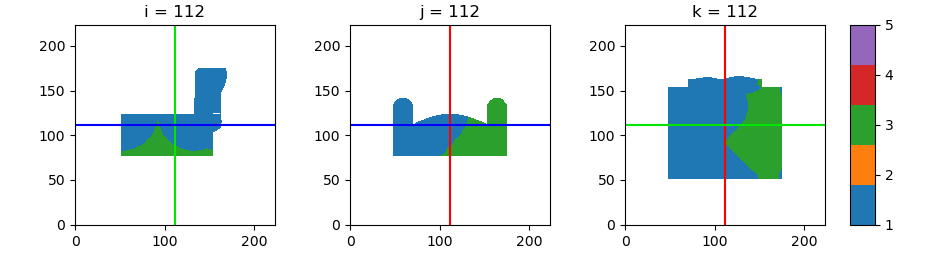

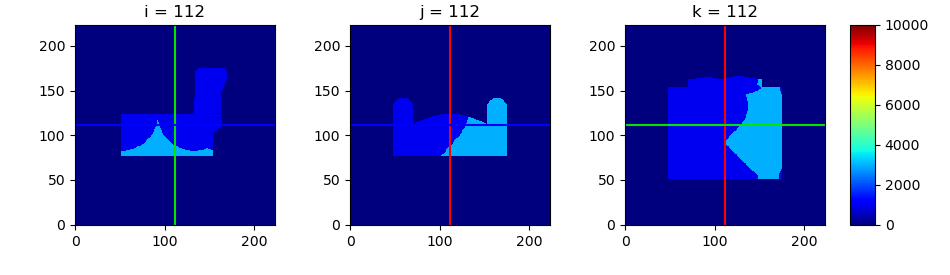

In [7]:
import project.visual.matplotlib

ex = examples[0]
image = project.core.fileio.load_nibabel(ex.paths['input_image'])
project.visual.matplotlib.SliceViewer(image.get_fdata(), cmap='gray')

mask = project.core.fileio.load_nibabel(ex.paths['material_mask'])
project.visual.matplotlib.SliceViewer(mask.get_fdata(), cmap=cmap, vmin=1, vmax=5)

E_true = project.core.fileio.load_nibabel(ex.paths['elastic_field'])
project.visual.matplotlib.SliceViewer(E_true.get_fdata(), cmap='jet', vmin=0, vmax=1e4)

In [8]:
train_config = config['training'].copy()
project.core.utils.pprint(train_config, 2, 100)

dict(len=9)
├── 'task':            dict(len=3)
|   ├── 'inputs':  list(len=1)
|   ├── 'targets': list(len=2)
|   └── 'losses':  dict(len=2)
├── 'split':           dict(len=4)
|   ├── 'key':        'category'
|   ├── 'test_ratio': 0.2
|   ├── 'val_ratio':  0.1
|   └── 'seed':       0
├── 'transform':       dict(len=4)
|   ├── 'normalize':  True
|   ├── 'image_mean': 1.0
|   ├── 'image_std':  1.0
|   └── 'apply_mask': True
├── 'loader':          dict(len=4)
|   ├── 'batch_size':  2
|   ├── 'shuffle':     True
|   ├── 'num_workers': 0
|   └── 'pin_memory':  True
├── 'model':           dict(len=2)
|   ├── 'backbone': dict(len=11)
|   └── 'heads':    dict(len=1)
├── 'physics_adapter': dict(len=5)
|   ├── 'nu_value':      0.4
|   ├── 'rho_bias':      1000
|   ├── 'rho_known':     True
|   ├── 'scalar_degree': 1
|   └── 'vector_degree': 1
├── 'pde_solver':      dict(len=2)
|   ├── '_class':        'WarpFEMSolver'
|   └── 'tv_reg_weight': 0.0001
├── 'optimizer':       dict(len=2)
|   ├── '_cla

In [9]:
import project.training
split_kws = train_config['split']
train_ex, test_ex, val_ex = project.training.split_on_metadata(examples, **split_kws)

len(train_ex), len(test_ex), len(val_ex)

Splitting examples
Test categories: {'CurioCabinet', 'VideoGameController', 'CellPhone', 'Recliner', 'CeilingLamp', 'Bathtub', 'Copier', 'MediaStorage', 'Refrigerator', 'ToyFigure', 'Bed', 'Ball', 'DiscCase', 'DrinkBottle', 'TableLamp', 'RubiksCube', 'Book', 'Microwave', 'Computer', 'FoodItem', 'TableClock', 'DoubleBed', 'Calculator'}
Test subjects:   {'wss.2394aad19bdb0ca8e751791317b66d8c', 'wss.28ab2b0d2d8c918b77e1c4f3e3547f0c', 'wss.2acb67458c17af08c4b494041bc63422', 'wss.1d2a6082238f011c22d3f170937c6a0b', 'wss.28cae57a8d9f858b92eb9b3d545b01bd', 'wss.263aa26d579b6def14c06184923f6962', 'wss.2725909a09e1a7961df58f4da76e254b', 'wss.2682cb34e7db8735bdc7fd7cf135ade2', 'wss.25370f9a01166beaa13edbe825cc0113', 'wss.29f66488d7507b0c5a93c9a5a7a08569', 'wss.2180c4770b8c4fce951b9c885c695a12', 'wss.24505c53438f8273399f45f7c8fcdfa9', 'wss.20dec770602a8ac2331999dc8823fe0d', 'wss.266aba6a1b941c3a2bf3161ae4fda942', 'wss.29830fb806fe23b29ccf01d06bf2094d', 'wss.2b78edd5bc31b19ae0681a1280473149', 'wss.

(68, 20, 10)

In [10]:
%autoreload
import project.datasets.torch

collate_fn = project.datasets.torch.collate_fn
train_set = project.datasets.torch.TorchDataset(train_ex)
train_loader = torch.utils.data.DataLoader(train_set, collate_fn=collate_fn, batch_size=1)
#stats = project.datasets.torch.accumulate_stats(train_loader, keys=['image', 'E', 'log_E'])
#stats

In [11]:
transform_kws = train_config['transform']
project.core.utils.pprint(transform_kws)

dict(len=4)
├── 'normalize':  True
├── 'image_mean': 1.0
├── 'image_std':  1.0
└── 'apply_mask': True


In [12]:
%autoreload
import project.datasets.torch

use_cache = False
train_set = project.datasets.torch.TorchDataset(train_ex, use_cache=use_cache, **transform_kws)
test_set = project.datasets.torch.TorchDataset(test_ex, use_cache=use_cache,  **transform_kws)
val_set = project.datasets.torch.TorchDataset(val_ex, use_cache=use_cache, **transform_kws)

In [13]:
loader_kws = train_config['loader'].copy()
loader_kws['batch_size']  = 1
loader_kws['num_workers'] = 0

collate_fn = project.datasets.torch.collate_fn
train_loader = torch.utils.data.DataLoader(train_set, collate_fn=collate_fn, **loader_kws)

if test_set:
    test_loader = torch.utils.data.DataLoader(test_set, collate_fn=collate_fn, **loader_kws)
else:
    test_loader = None

if val_set:
    val_loader = torch.utils.data.DataLoader(val_set, collate_fn=collate_fn, **loader_kws)
else:
    val_loader = None


In [14]:
import project.training

task_kws = train_config['task'].copy()

task_kws['inputs']  = ['image']
task_kws['targets'] = ['material']
task_kws['losses']  = {'material': 'CE'}

#task_kws['inputs']  = ['material']
#task_kws['targets'] = ['logE']
#task_kws['losses']  = {'logE': 'MSE'}

task = project.training.TaskSpec(**task_kws)
task_kws

{'inputs': ['image'], 'targets': ['material'], 'losses': {'material': 'CE'}}

In [15]:
%autoreload
import project.models
import copy

model_kws = copy.deepcopy(train_config['model'])

if True:
    backbone_kws = model_kws['backbone']
    backbone_kws['_class']        = 'UNet3Dv2'
    backbone_kws['out_channels']  = 16
    backbone_kws['conv_channels'] = 16
    backbone_kws['n_conv_units']  = 2
    backbone_kws['n_sub_levels']  = 3
    backbone_kws['kernel_size']   = 3
    backbone_kws['relu_leak']     = 0.1
    backbone_kws['norm_type']     = 'group'
    backbone_kws['num_groups']    = 4
    backbone_kws['upsample_mode'] = 'trilinear'

project.core.utils.pprint(model_kws)

model = project.models.build_model(task, model_kws)
model

dict(len=2)
├── 'backbone': dict(len=11)
|   ├── '_class':        'UNet3Dv2'
|   ├── 'out_channels':  16
|   ├── 'conv_channels': 16
|   ├── 'n_conv_units':  2
|   ├── 'n_sub_levels':  3
|   ├── 'kernel_size':   3
|   ├── 'relu_leak':     0.1
|   ├── 'norm_type':     'group'
|   ├── 'num_groups':    4
|   ├── 'pooling_type':  'max'
|   └── <1 more items>
└── 'heads':    dict(len=1)
    └── 'elasticity': dict(len=4)


MultiTaskModel(
  (backbone): UNet3Dv2(
    (enc): ConvBlock3D(
      (unit0): ConvUnit3D(
        (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (unit1): ConvUnit3D(
        (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (down): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (sub): UNet3Dv2(
      (enc): ConvBlock3D(
        (unit0): ConvUnit3D(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
          (norm): GroupNorm(4, 32, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slo

In [16]:
project.models.count_params(model)

backbone.enc.unit0.conv.weight                     432	(16, 1, 3, 3, 3)
backbone.enc.unit0.norm.weight                     16	(16,)
backbone.enc.unit0.norm.bias                       16	(16,)
backbone.enc.unit1.conv.weight                     6912	(16, 16, 3, 3, 3)
backbone.enc.unit1.norm.weight                     16	(16,)
backbone.enc.unit1.norm.bias                       16	(16,)
backbone.sub.enc.unit0.conv.weight                 13824	(32, 16, 3, 3, 3)
backbone.sub.enc.unit0.norm.weight                 32	(32,)
backbone.sub.enc.unit0.norm.bias                   32	(32,)
backbone.sub.enc.unit1.conv.weight                 27648	(32, 32, 3, 3, 3)
backbone.sub.enc.unit1.norm.weight                 32	(32,)
backbone.sub.enc.unit1.norm.bias                   32	(32,)
backbone.sub.sub.enc.unit0.conv.weight             55296	(64, 32, 3, 3, 3)
backbone.sub.sub.enc.unit0.norm.weight             64	(64,)
backbone.sub.sub.enc.unit0.norm.bias               64	(64,)
backbone.sub.sub.enc.unit1.co

1909942

In [17]:
import project.physics

pde_solver_kws = train_config['pde_solver'].copy()
pde_solver_cls = pde_solver_kws.pop('_class')

physics_adapter = project.physics.PhysicsAdapter(
    pde_solver_cls=pde_solver_cls,
    pde_solver_kws=pde_solver_kws,
    **train_config['physics_adapter']
)
physics_adapter

In [18]:
import torch.optim
optimizer_kws = train_config['optimizer'].copy()
optimizer_kws['lr'] = 5e-4
optimizer_cls = getattr(torch.optim, optimizer_kws.pop('_class'))
optimizer = optimizer_cls(model.parameters(), **optimizer_kws)

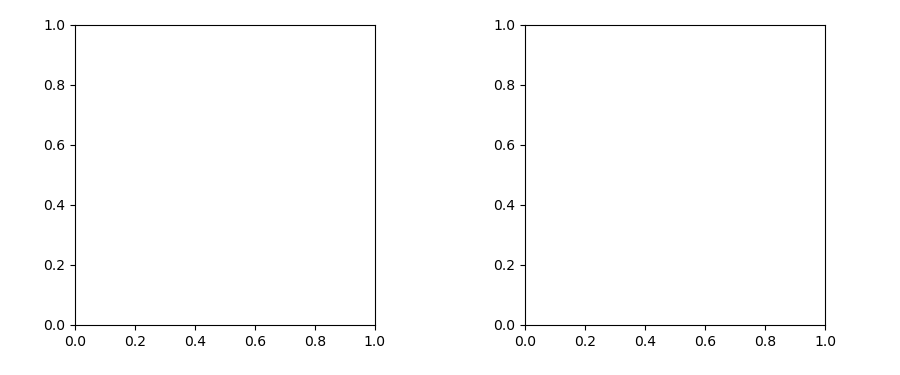

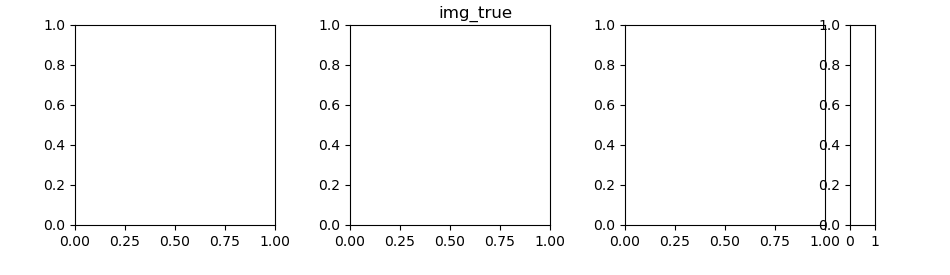

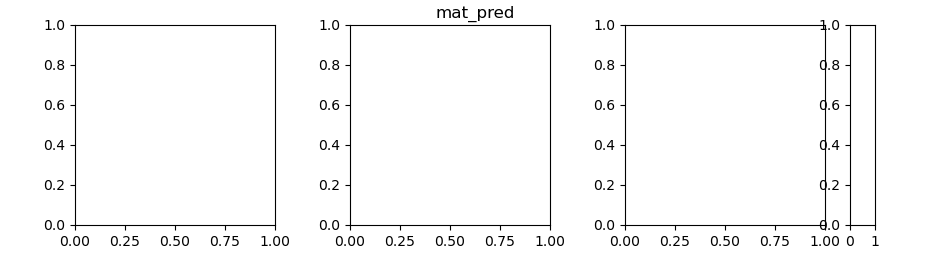

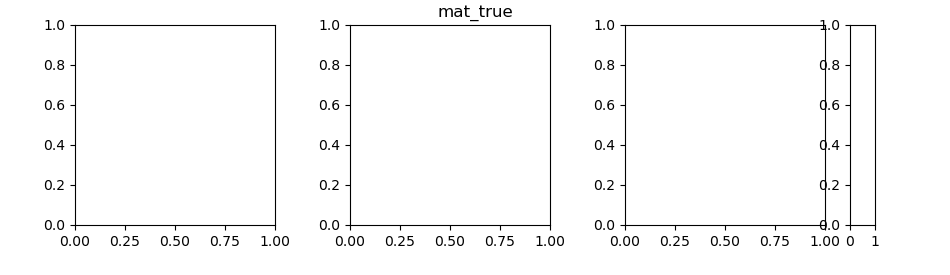

In [19]:
%autoreload
import project.training
import project.evaluation

trainer_kws = train_config['trainer'].copy()

trainer = project.training.Trainer(
    task=task,
    model=model,
    optimizer=optimizer,
    physics_adapter=physics_adapter,
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    callbacks=[
        project.evaluation.LoggerCallback(),
        project.evaluation.PlotterCallback(task.plotter_keys),
        project.evaluation.ViewerCallback(task.viewer_keys, n_labels=task.material_labels),
        #project.evaluation.EvaluatorCallback(n_labels=task.material_labels)
    ],
    eval_physics=False
)
#trainer.load_state(epoch=20)

In [20]:
num_epochs = max(20, 2000 // len(examples))
num_epochs

20

In [ ]:
%autoreload
trainer.train(num_epochs=num_epochs, val_every=0)

Start training loop
===== Epoch 0 =====
Saving checkpoints/checkpoint00000.pt
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/meshes/mask_regions_uniform-seed_image_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/fields/mask_regions_uniform-seed_elastic.nii.gz
[Epoch 0 | Train batch 0/68] loss = 3.2557e+00 | time = 28.8796s | memory = 29 / 25512 / 2164 MiB


/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/visual/matplotlib.py:102: UserWarning: Adding colorbar to a different Figure <Figure size 950x275 with 4 Axes> than <Figure size 950x275 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(self.im_k, cax=self.cbar_ax)


Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1b36df7ed7ddd974c538fbfc1e40dbe0/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1b36df7ed7ddd974c538fbfc1e40dbe0/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1b36df7ed7ddd974c538fbfc1e40dbe0/meshes/mask_regions_uniform-seed_image_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1b36df7ed7ddd974c538fbfc1e40dbe0/fields/mask_regions_uniform-seed_elastic.nii.gz
[Epoch 0 | Train batch 1/68] loss = 2.9908e+00 | time = 0.6341s | memory = 29 / 14652 / 20824 MiB
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem